# Developing a Machine Learning Model to Predict Hypertension Risk 
### Jacob Halle jh8755

#### 1.0 Introduction

Hypertension is a prevelant condition that is correlated with many serious health complications, including heart failure, brain damage, and organ dysfunction. Despite the risks associated with hypertension, approximately 46% of adults with hypertension are unaware they have the condition (1). The availability and access of next generation sequencing technologies presents a novel opportunity to assess hypertension risk on an individual genomic level. For this project, I used publicly available genotypic and phenotypic data to develop a machine learning model to classify individuals as at risk or not at risk for having or developing hypertension based on a combination of genomic and physical characteristics. The model was able to correctly classify a significant proportion of individuals, and provides additional insights on the phenotypic and genotypic factors that are most associated with developing and sustaining hypertension. 

#### 2.0 Materials and Methods

<center>
Figure 1. Data Curation Workflow
</center>

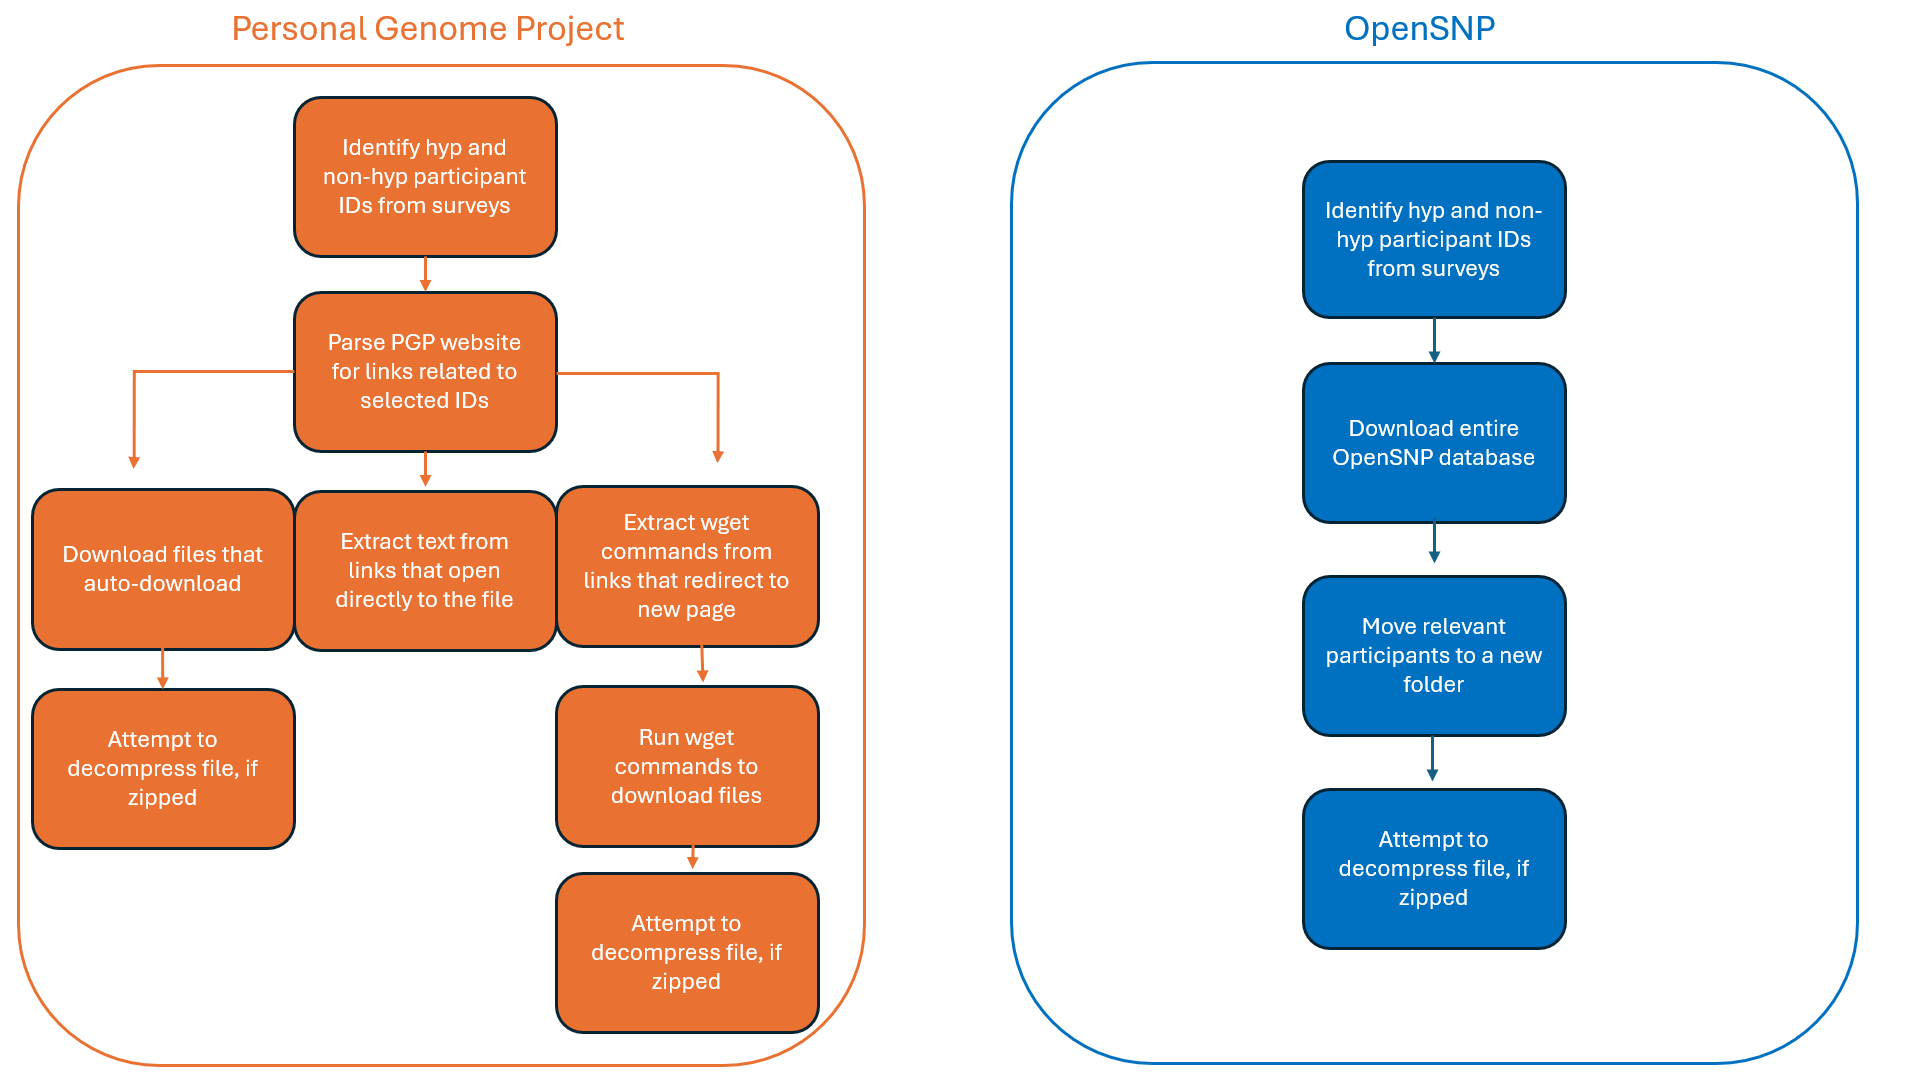

Figure 1. illustrates the steps that were taken to curate the data used in this project. Most Genome Wide association Studies (GWAS) have protected data that is not available to graduate students. However, there are two websites that allow participants to upload their results of genetic sequencing with full disclosure to the public. These resources are the Harvard Personal Genome Project (PGP) and OpenSNP. The methods for aquiring data from these two sources varied significantly.

PGP provides researchers with user IDs of participants and individual download links for various sequencing data files (3). For this project, I was only interested in variant call files (VCF). Additionally, participants are able to fill out surveys about their phenotypes. From these surveys, I was able to identifty the participant IDs of those that identified as hypertensive or not. Using the participant IDs, a program was written to automatically parse through the PGP website to identify VCF download links of participants that had supplied information regarding their hypertension status. These download links functioned in one of three ways. Option 1: The links initiated an autodownload of a data file. These files were coded to be downloaded to a specific directory, then a function attemped to unzip the files if they were compressed. Option 2: the links opened a new tab that contained the VCF file as text. In this case, the text was parsed and saved as a text file. Option 3: the link redirected to a new webpage that listed a wget command to download the files. For these links, the wget command was extracted from the webpage, and autonomously executed through python. Then similary to scenario 1, if the files were compressed they were autonomously extracted.

OpenSNP also contained survey data about its participants. I was able to then identify OpenSNP user IDs that would be relevant to this project. In contrast to PGP, OpenSNP allows researchers to download their entire database at once. Then I created a program to move all files that contain a relevant ID to a separate directory. Finally, the same decompressing function was applied to the relevant files. 

After data for all relevant participants had been downloaded, my dataset consisted of nearly 400 participants. 

<center>
Figure 2. Data Processing
</center>

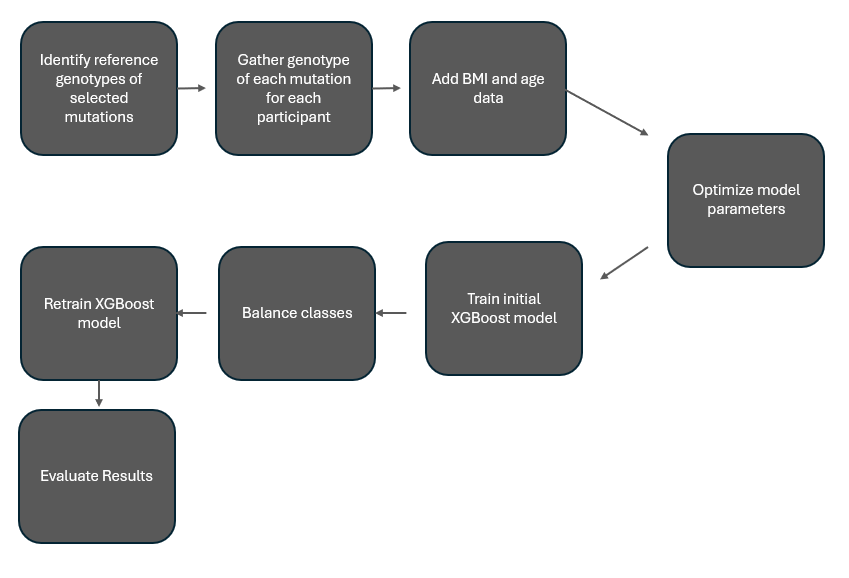

Once all the VCF files had been curated, the next step was to process the data for use in machine learning. A study by The International Consortium for Blood Pressure Genome-Wide Association Studies (4) identified 29 variants that are thought to be linked to signficant increases or decreases in blood pressure. For each of these mutations, I identified the reference allele so that the genotype at each location for each participant could be identified. If a participant was homozygous for the reference allele at a specific location, the genotype was classified as "0". Heterozygous cases were denoted as "1", and homozygous alternate cases "2". Next, BMI, age and sex data were added for each participant and these values were standardized. See Figure 3 for the processed data that was fed into the machine learning algorithm. At this point, the state of missing data was assessed. For each RSID, there was at least 1 participant that did not have data. To limit the impact of missing data and to not overconstrain the model, the ten RSIDs with the fewest missing data values were chosen for model training. Participant entries for age and weight were inconsistent as well. Rather than removing data points, which would lead to substantial data loss, a machine learning model that is well equiped to handle missing values was selected. This model was Extreme Gradient Boosting (XGBoost). 

<center>
    Figure 3. Processed Data Example
</center>

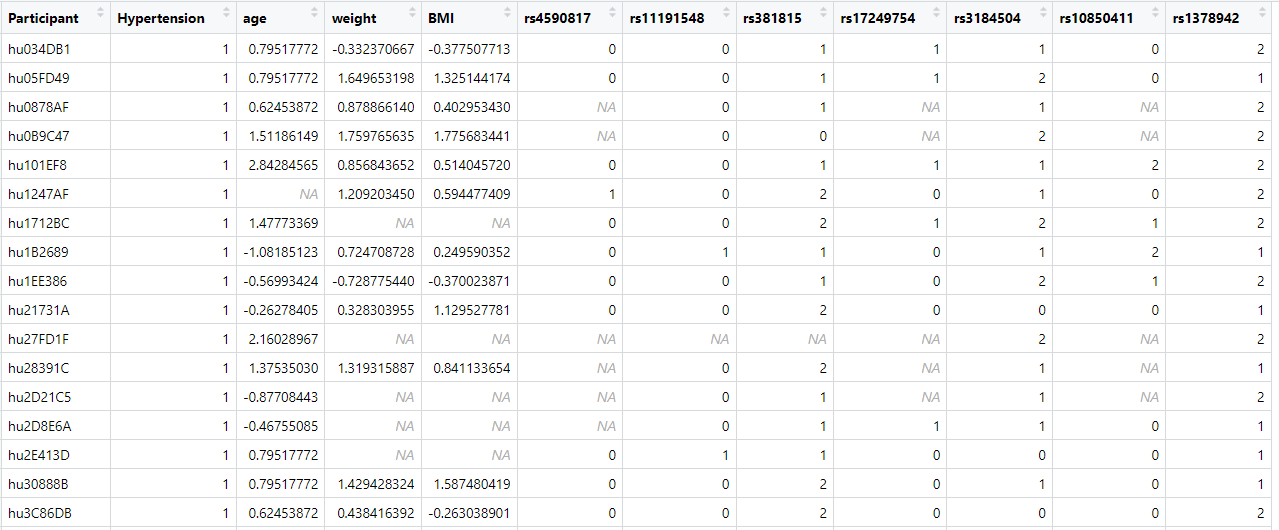

XGBoost has several parameters that can be adjusted for optimal model performance. To find the ideal parameters, I performed a grid search. In brief, this is a technique where several values of each parameter are supplied, and each combination of parameters is used to train and evaluate a model using 10-fold cross validation. The best combination of parameters can be seen in Figure 4. 80% of the data was randomly sampled for training, and the remaining 20% was set aside for testing. Of the 80% training data, 20% of it was separated into a validation set for tuning of the parameters. 

<center>
    Figure 4. Optimal XGBoost model parameters
</center>

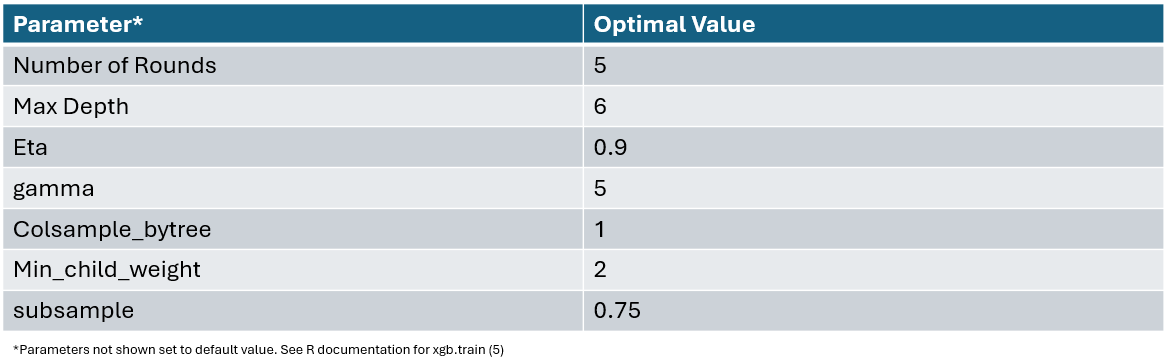

With the optimal parameters set, the model was evaluated using Monte Carlo cross validation with 1000 iterations. This is a technique that involves creating many random training-test splits and evaluating model performance on each. 

The initial results of this model was underwhelming. The model produced predictions signficantly more accurately than simply always selecting the majority class (normal) in about 25 out of 100 random training-test splits. This was likely due to class imbalance and missing data. To resolve this issue, participants in the normal class were removed until there were the same number of hypertensive and normal participants. Participants were preferentially removed based off the quantity of missing data, as these participants contributed the least to training and were difficult to classify. Initial feature importance analysis of the models that produced statistically signficant predictions showed that age and BMI were the most important features. Therefore, if a normal participant had no age or BMI data, they were removed. This did not reduce the number of normal participants down to the level of hypertensive participants, so random normal participants were removed if they were missing either age or BMI until the desired number was reached. Once the classes were balanced, the model performed much better.

#### 3.0 Results and Discussion

To determine if the model predicts more accurately than randomly selecting a class, the p-values (accuracy vs No Information Rate) were plotted on a histogram, see Figure 5. At a significance level of 0.05, the overwhelming majority of models had a statistically significant higher accuracy than random guessing. This indicates that an XGBoost model trained on 80% of this dataset and tested on 20% can produce statistically signficant predictions with the parameters stated above.   

<center>
    Figure 5.
</center>

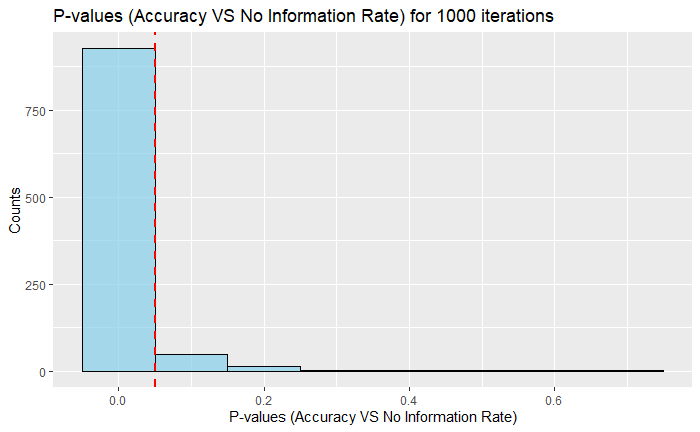 

The accuracy of 1000 iterations was approximately 72% with a standard deviation of 5.4%, see Figure 6. This indicates reasonable effectiveness, but the model's performance can be affected by the training split. A likely reason is the amount of missing data, especially for age and BMI. Participants missing these metrics are difficult for the model to classify, leading to poor performance on test sets with many such participants.

<center>
    Figure 6.
</center>

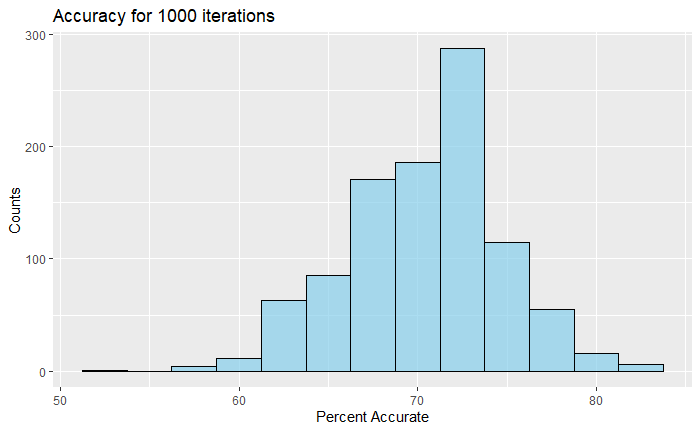

The average values for accuracy, recall, specificity, F1 score, precision, and negative predictive value (NPV) are all similar, indicating that the model performs consistently when predicting both hypertensive and non-hypertensive participants. See Figure 7. This lack of discrepancies between metrics suggests a balanced model across both classes. Further optimization of the decision threshold was attempted, but a threshold of 0.5 resulted in the most balanced results for each metric.

<center>
    Figure 7. Model Assessment Metrics

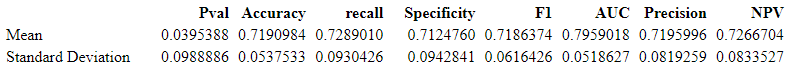

Figure 8 shows the average ROC curve as a black line and the 95% confidence interval shown in yellow and the bounds outlined in red. A model that provides no insights would produce a diagonal line. The average curve for this model presents a curve being pulled towards the top left corner, indicating an ability to correctly identify true positives while minimizing false positives. This graph indicates the robustness of the model to perform better than a random model at various thresholds as well.

<center>
    Figure 8.
</center>

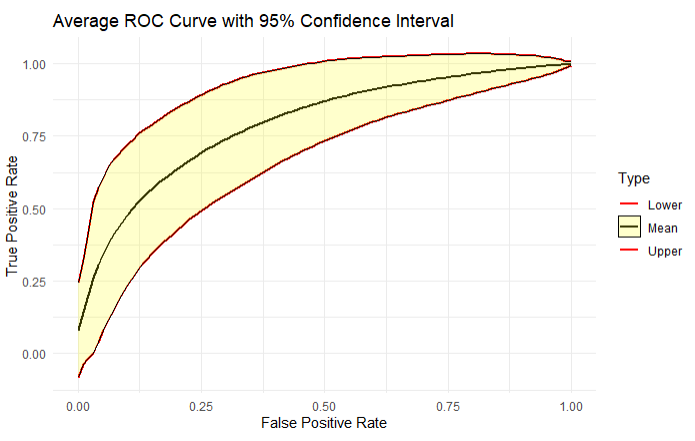

Figure 9 presents the average and standard deviation of the gain for each feature, as well as the signficance rate for each feature. Gain is the average improvement in the model's performance when that feature is used as a split in the decision tree. Signficance rate is the percentage of models that used that feature in making predictions. Age was the feature that contributed the most to accurate predictions and was incorporated by every model. BMI also signficantly contributed to model performance and was also always included. There were two mutations that had a small gain contribution, but were included in over half the models (rs17367504 and rs1799945). Interestingly, sex was less important to model accuracy than several genetic mutations. It is important to note that these mutations may raise or lower blood pressure.

These results suggest that hypertension risk is largely attributed to non-genetic factors, with genetic factors playing a secondary role. Age and BMI had consistently more contribution to model performance than any combination of genetic factors explored in this project. That is not to say that some mutations cannot be useful diagnostic tools, but age and BMI are much stronger indicators based off this model.

<center>
    Figure 9. Feature Importance
</center>

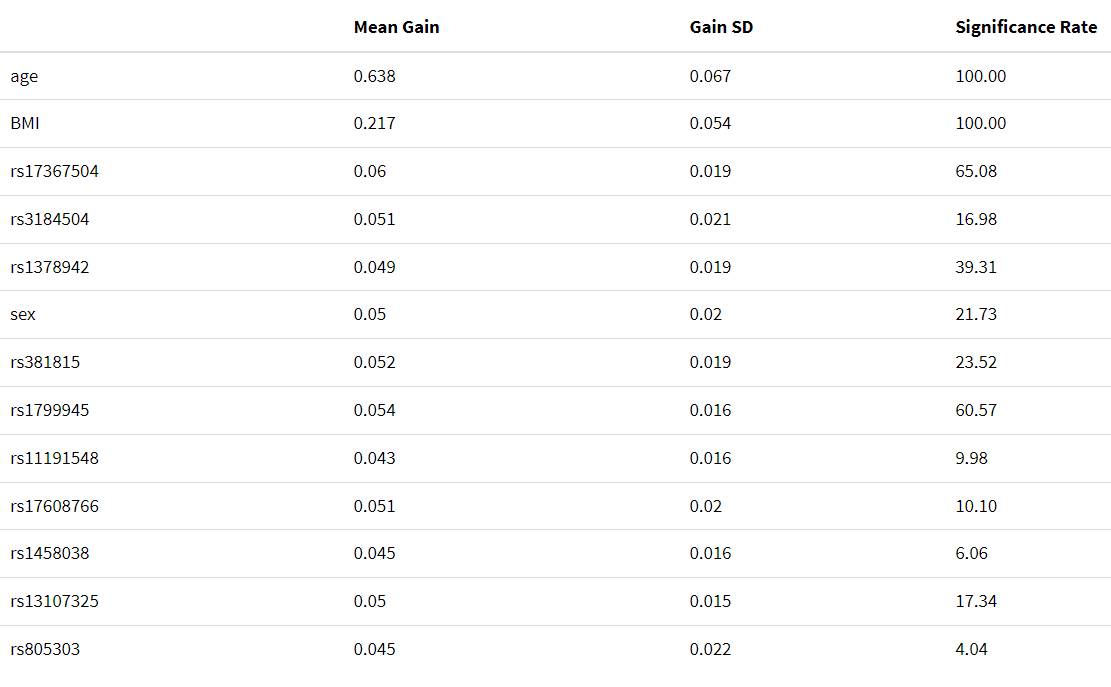

Figure 10. Shows the partial dependence plots for the top 4 features by signficance rate. Negative numbers mean that the feature at the given x-value contributes to a non-hypertensive prediction, and positive numbers hypertensive. The x-values for age and BMI are standardized to this dataset, and the RSIDs represent the number of alternate alleles. These plots are not averaged for all iterations; they represent only one model and are presented here to explain general trends.

As expected, increasing age and BMI contributed to a higher probability of hypertension. Both age and BMI near the mean of this data was not a signficant predictor. However, when a participant presented age or BMI 2 standard deviations above or below the mean, the feature became very telling of the participants class. Interestingly, the RSIDs with the two highest significance rates, rs17367504 and rs1799945, both lowered the risk of hypertension when they were present for a homozygous alternate allele. rs17367504 has no associated conditions listed in ClinVAR, so the mechanism through which this mutation affects blood pressure requires further investigation to uncover. (6). rs1799945 has a moderate association with Hemochromatosis type 1, but it is also unclear how this mutation contributed to lower blood pressure (7). 

<center>
    Figure 10. Partial Dependence Plots of the Top 4 Features by Signficance Rate
</center>

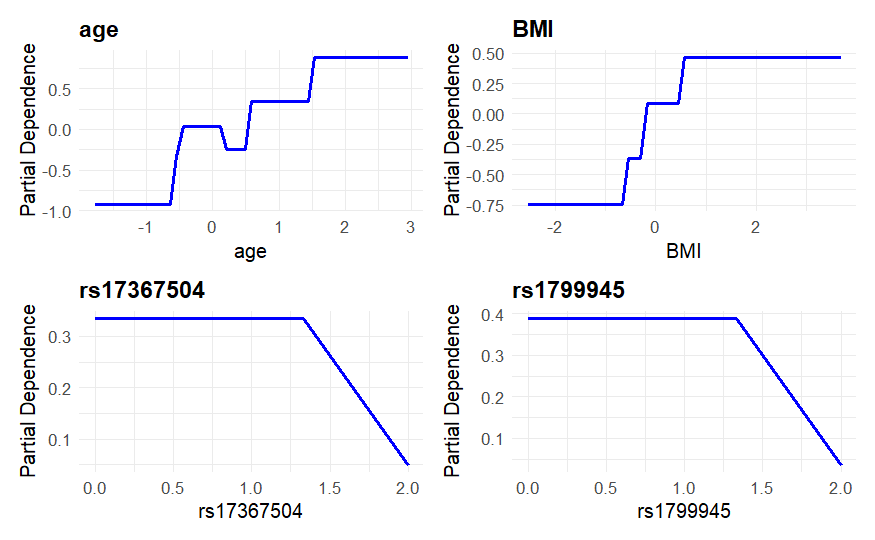

There are several limitations and options for improvement in this project. As discussed previously, not all participants had data for each feature. This likely led to lower accuracy than if the model was built using a complete dataset, since there was less data to train on for certain features and less to aid the model in making predictions during testing. The quantity of data also limited the number of features that could be assessed. Thirteen features were included in the final model; including any more would risk over constraining the model. If more participants were available, such is the case for large Genome-wide association studies, many more mutations could be examined and novel mutations that impact hypertension could be identified. Other important features, such as smoking, diet, race, and exercise did not have enough survey responses to include in this project.

#### 4.0 Conclusion

In this project, I curated data from open source websites through an automated process. Website parsing, managing different types of files, and dealing with bad or currupted data were all challenges that were overcome in this process. This resulted in nearly 400 files of varying formats that I was able to extract the necessary genetic information from. Using this data, an XGBoost model was trained, parameters were optimized, and the model was evaluated using Monte carlo cross validation with 1000 iterations. Nearly all of the models trained were able to correctly classify participants as hypertensive or not better than a random predictor. The average model was 72% accurate, and the ROC curve suggests the model is robust at making predictions given different thresholds. This model provides insight into the features that can be used to make accurate predictions, as well as the partial dependencess of each feature on the predictions at different values.

The methodology presented in this project could be applied to a larger scale project including many more participants and additional survey questions. It would be interesting to see how well this model could perform given a larger, complete data set and additional features such as smoking, diet, race, and exercise.

References
1. World Health Organization. Hypertension: Key facts. Available at: https://www.who.int/news-room/fact-sheets/detail/hypertension. Accessed August 7, 2024.
2. Personal Genome Project. Public Genetic Data. Harvard Medical School. Available from: https://my.pgp-hms.org/public_genetic_data.
3. openSNP. openSNP: Crowdsourced Genetic Data. Available from: https://opensnp.org/
4. International Consortium for Blood Pressure Genome-Wide Association Studies; Ehret GB et all, Genetic variants in novel pathways influence blood pressure and cardiovascular disease risk. Nature. 2011 Sep 11;478(7367):103-9. doi: 10.1038/nature10405. PMID: 21909115; PMCID: PMC3340926. Link: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3340926/ Published 2011
5. xgboost package. xgb.train: Training function for xgboost models. RDocumentation. Available from: https://www.rdocumentation.org/packages/xgboost/versions/1.7.8.1/topics/xgb.train
6. NCBI. rs17367504: Clinical Significance. Available from: https://www.ncbi.nlm.nih.gov/snp/rs17367504#clinical_significance
7. National Center for Biotechnology Information. ClinVar; [VCV000000010.111], https://www.ncbi.nlm.nih.gov/clinvar/variation/VCV000000010.111 